In [ ]:
import sys
sys.path.append('..')
from settings import *
from fermiqp.lattice import *
import matplotlib.colors as colors
import fermiqp_style as fqpstyle
from math import factorial

# fqpstyle.set_theme()

In [5]:
fqpstyle.plt_colors

['#2A6D70',
 '#DBA032',
 '#7CB8C4',
 '#C42158',
 '#B89769',
 '#149C71',
 '#B36619',
 '#7D227D']

In [23]:
T = 200e-6

n_max = 20
omega_trap = 1.9e6
rho = np.exp(-hplanck*omega_trap/(kB*T))

ns = np.arange(n_max)

cn = np.array([rho**n for n in ns])
cn = cn/np.sum(cn)


print(cn[0]/cn.sum())
print(np.sum(cn*ns))

0.36648768529636555
1.7267295575695614


/var/folders/39/7zvqwx812jq46_02fv74x1vr0000gn/T/ipykernel_76128/3261700892.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(hbar/mass/trap_freq/2/pi)


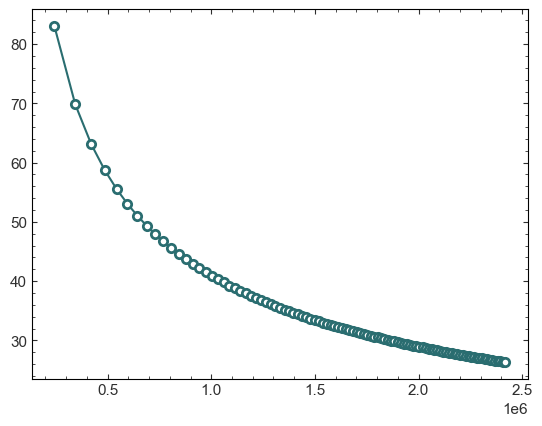

In [24]:
def trap_freq2a_ho(trap_freq):
    return np.sqrt(hbar/mass/trap_freq/2/pi)


pinn = OpticalLattice1D(a=752e-9)

U = np.linspace(0,1,100)*1e8
omega_trap = pinn.trap_freq(U=U)
a_ho = trap_freq2a_ho(omega_trap)

plt.plot(omega_trap, a_ho*1e9)


sigmax = np.array([[0,1],[1,0]])
sigmaz = np.array([[1,0],[0,-1]])

In [25]:
from scipy.special import assoc_laguerre as L
from math import factorial
from scipy.linalg import expm


omega_trap = 1.5e6
a_ho = trap_freq2a_ho(omega_trap)


n_max = 20

T = 200e-6
rho = np.exp(-hplanck*omega_trap/(kB*T))

ns = np.arange(n_max)

cn = np.array([rho**n for n in ns])
cn = cn/cn.max()

eta = (2*pi/0.671e-6)*np.sqrt(7)/2*np.sqrt(hbar/2/mass/omega_trap/2/pi)
print(eta)

0.29279171279760774


In [26]:
eta = 0.4
n = 20
# psi_ext = cn.reshape((n,1))
psi_ext = np.zeros((n,1))
psi_ext[1] = 1
psi_spin = np.array([1,0]).reshape((2,1))
psi0 = np.kron(psi_ext, psi_spin)

rho0 = psi0 @ psi0.T

H0 = np.kron(np.diag(np.arange(n)+0.5)*omega_trap, np.eye(2))

H_ext = np.eye(n) * 0.0j
for i in range(n):
    for j in range(n):
        if i <= j :
            H_ext[i,j] = np.sqrt(factorial(i)/factorial(j))*(1j*eta)**(j-i)*L(eta**2, i, k=j-i)*np.exp(-eta**2/2)
        else:
            H_ext[i,j] = (np.sqrt(factorial(j)/factorial(i))*(1j*eta)**(i-j)*L(eta**2, j, k=i-j)*np.exp(-eta**2/2)).conj()


In [27]:
def raman_spectrum(eta=0.3, init=0, omega_trap=2e6, omg=100e3, sigma_dopper=0.6e6, nmax=10):
    # eta = 0.5
    n = nmax
    # psi_ext = cn.reshape((n,1))
    psi_ext = np.zeros((n,1))
    psi_ext[init] = 1
    psi_spin = np.array([1,0]).reshape((2,1))
    psi0 = np.kron(psi_ext, psi_spin)

    rho0 = psi0 @ psi0.T

    H0 = np.kron(np.diag(np.arange(n)+0.5)*omega_trap, np.eye(2))

    H_ext = np.eye(n) * 0.0j
    for i in range(n):
        for j in range(n):
            if i <= j :
                H_ext[i,j] = np.sqrt(factorial(i)/factorial(j))*(1j*eta)**(j-i)*L(eta**2, i, k=j-i)*np.exp(-eta**2/2)
            else:
                H_ext[i,j] = (np.sqrt(factorial(j)/factorial(i))*(1j*eta)**(i-j)*L(eta**2, j, k=i-j)*np.exp(-eta**2/2)).conj()

    delta_list = np.linspace(-2.5e6, 2.5e6, 2000)

    delta_dopper_list = delta_list*4

    # omg = 100e3
    t = 0.5/omg/eta
    t = 100e-6


    p = []

    for delta in delta_list:

        
        H_spin = 0.5*omg*sigmax
        H = H0 + np.kron(H_ext, H_spin) + np.kron(np.eye(n), 0.5*(delta)*sigmaz)
        

        psi = expm(-1j*2*pi*H*t) @ psi0

        p.append((np.abs(psi[1::2])**2).sum())

    p = np.array(p)

    # delta_doppler = .6e6

    p_doppler = 0
    for i, delta in enumerate(delta_list):
        p_doppler += np.exp(-(delta_dopper_list-delta)**2/2/sigma_dopper**2/2)*p[i]

        
    return p_doppler

In [30]:
omega_trap = 1.8e6

eta = (2*pi/0.671e-6)*2*np.sqrt(hbar/2/mass/omega_trap/2/pi)
print(eta)
# eta = 0.5

n_max = 20

T = 200e-6
rho = np.exp(-hplanck*omega_trap/(kB*T))

ns = np.arange(n_max)

cn = np.array([rho**n for n in ns])
cn = cn/cn.max()


omg_list = [50e3]

p_list = []

for omg in omg_list:

    p = []
    for i in range(len(cn)):
        p.append(raman_spectrum(eta=eta, init=i, omega_trap=omega_trap, omg=omg, sigma_dopper=0.01e6, nmax=n_max)*cn[i])

    p = np.array(p)

    p = np.sum(p,axis=0)
    p_list.append(p)



0.40409095412497426


Text(0.5, 0, 'Raman detuning')

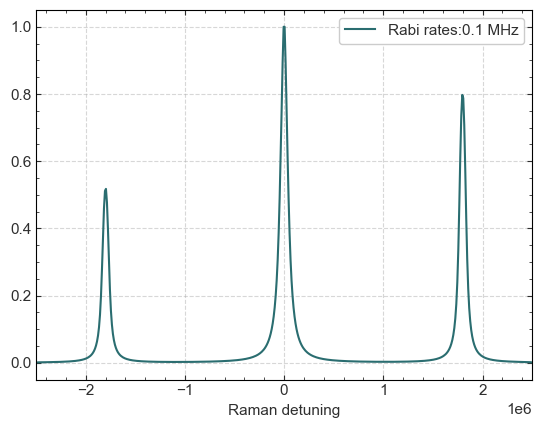

In [31]:
delta_list = np.linspace(-10e6, 10e6, len(p))

i = np.argmin(np.abs(delta_list))

for j in range(len(p_list)):
    plt.plot(delta_list, p_list[j]/p_list[j].max(), label='Rabi rates:%.1f MHz'%(omg_list[j]/1e6), marker='')
# plt.plot(delta_list, pn[2,:])

plt.xlim([-2.5e6, 2.5e6])
plt.legend()
plt.grid()
plt.xlabel('Raman detuning')

In [2]:
omega_trap = 1.2e6

T_list = (np.arange(30)+1)*20e-6

eta = (2*pi/0.671e-6)*2*np.sqrt(hbar/2/mass/omega_trap/2/pi)
print(eta)
# eta = 0.5

n_max = 20

pr = []
p0 = []
pb = []

nbar = []
frac_g = []

ir = np.argmin(np.abs(delta_list+omega_trap))
i0 = np.argmin(np.abs(delta_list+0*omega_trap))
ib = np.argmin(np.abs(delta_list-omega_trap))

for T in T_list:

    rho = np.exp(-hplanck*omega_trap/(kB*T))

    ns = np.arange(n_max)

    cn = np.array([rho**n for n in ns])
    cn = cn/cn.sum()

    nbar.append(np.sum(cn*ns))
    frac_g.append(cn[0])

    omg = [50e3]

    p_list = []

    for omg in omg_list:

        p = []
        for i in range(len(cn)):
            p.append(raman_spectrum(eta=eta, init=i, omega_trap=omega_trap, omg=omg, sigma_dopper=0.01e6, nmax=n_max)*cn[i])

        p = np.array(p)

        p = np.sum(p,axis=0)

        pr.append(p[ir])
        p0.append(p[i0])
        pb.append(p[ib])

    



0.49490832364029613


NameError: name 'delta_list' is not defined

The imbalance is the ratio between the maxima

In [3]:
# mpl.rcParams.update(
#     {
#         "lines.markeredgewidth": 2,
#         "lines.markersize": 7,
#     }
# )

from scipy.interpolate import interp1d

pr = np.array(pr)
p0 = np.array(p0)
pb = np.array(pb)

x = nbar
y = pr/pb

xs = np.linspace(0,7,1000)
f = interp1d(x, y, kind='quadratic', fill_value="extrapolate")
ys = f(xs)

plt.figure(figsize=(5,4))


plt.plot(xs, ys, label='Theory', color="#a9a9a9", marker="None")



plt.grid()

plt.xlim([0,xs[-1]])
plt.ylim([0.0, 1])
plt.legend()
plt.ylabel('Red/blue sideband imbalance')
plt.xlabel(r'$\langle n\rangle$')
plt.savefig('Raman SB.png')


ValueError: cannot reshape array of size 0 into shape (0,newaxis)